In [1]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct

# Linear-Quadratic Regulator (LQR)
---

LQR es una técnica en donde es posible ubicar los polos del sistema en un lugar especifico para lograr un desempeńo deseado. Esto se realiza de una forma muy similar a lo visto en Pole Placement, aplicando una ganancia K en la realimentación. Sin embargo, en LQR se optimizan las ganancias para encontrar la relación deseada entre el esfuerzo y el desempeño del sistema.




 Imaginemos un ejemplo ilustrativo. Suponga que debe trasladarse a la universidad utilizando diferentes metodos de transporte, donde con cada uno tardará un tiempo $t$ (desempeño), pero con un precio asociado (esfuerzo).

 
|           | Tiempo (minutos) | Precio (Miles de pesos) |
|:---------:|:----------------:|:-----------:|
| Bicicleta |        30        |      0      |
| Automovil |        20        |    15    |
|    Bus    |        45        |     2.75    |


¿Cúal sería la mejor forma de llegar a la universidad?

**Depende**. La respuesta varía dependiendo de que queremos priorizar. 

Si tomamos una función de coste total $J$:

$$J = Q*tiempo + R*Precio$$

Donde Q y R son las prioriodades que se les da a cada una de las variables del sistema, por ejemplo, si quisieramos priorizar (penalizar) el precio sobre el tiempo, tendríamos los siguientes resultados:

$Q=1, R=2$


|           | Tiempo (minutos) | Coste (Miles de pesos) |   J   |
|:---------:|:----------------:|:-----------:|:-----:|
| Bicicleta |        30        |      0      |   30  |
| Automovil |        20        |    15       | 50    |
|    Bus    |        45        |     2.75    |  50.5 |

En este caso, el metodo de transporte optimo sería la bicicleta. Si por el contrario penalizamos el tiempo:

$Q = 2, R=1$

|           | Tiempo (minutos) | Coste (Miles de pesos) |   J   |
|:---------:|:----------------:|:----------------------:|:-----:|
| Bicicleta |        30        |            0           |   60  |
| Automovil |        20        |           15           |   55  |
|    Bus    |        45        |          2.75          | 92.75 |

De esta forma, el metodo optimo sería el automovil


Aplicado en sistemas dinámicos, podemos establecer $Q$ como una matriz cuadrada donde en la diagonal esta el coste de cada una de las variables del sistema, mientras que $R$ es tambien una matriz diagonal con el coste de cada una de las entradas al sistema. De esta manera, podemos definir la función de coste como:

$$J = \int_0^\infty (x^TQx + u^TRu)$$

De esta forma, se podemos plantear un problema de optimización donde encontremos las constantes K tal que minimicen la función de coste.

# Ejemplo con UNMotorDC
---

Podemos realizar varios experimentos con diferentes parametros de $Q$ y $R$ para comparar los resultados en el desempeño y la energía utilizada en el sistema

## Modelo en espacio de estados de un motor DC

El modelo en variables de estado lo podemos definir como:

$$x = 
\begin{bmatrix}
-b/J & K_t/J\\
-K_e/L & -R/L
\end{bmatrix}
\begin{bmatrix}
\dot{\theta} \\
i
\end{bmatrix}
+
\begin{bmatrix}
0 \\
1/L
\end{bmatrix} V
$$

$$
y = \begin{bmatrix}
1 & 0
\end{bmatrix}
\begin{bmatrix}
\dot{\theta}\\
i
\end{bmatrix}
$$

In [62]:
# Constantes del motor
b = 0.1 # Fricción
J = 0.01 # Momento de inercia del rotor
Kt = 0.01 # Constante del torque del motor
Ke = 0.01 # Constante de fuerza electromotriz
L = 0.5 # Inductancia
R = 1 # Resistencia

# Modelo en espacio de estados
A = np.asarray([[0, 1, 0], [0, -b/J, Kt/J],[0, -Ke/L, -R/L]])
B = np.asarray([[0], [0],[1/L]])
C = np.asarray([1, 0, 0])
D = 0

system = ct.ss(A, B, C, D)

## Establecer Q y R

Para este sistema, podemos definir la matriz $Q$ de la forma:

$$Q=
\begin{bmatrix}
\textit{Coste de la velocidad angular} & 0\\
0 & \textit{Coste de la corriente}
\end{bmatrix}
$$

Mientras que $R$ representa el coste del voltaje, para este sistema es un valor escalar.

## LQR en python
---

In [ ]:
# funciones utiles

def simulate_system(lqr_sys, K_lqr):
    t = np.linspace(0, 10, 100)  # Tiempo de simulación
    step_input = np.ones_like(t)
    _, y, x = ct.forced_response(lqr_sys, T=t, U=step_input, return_x=True)
    u = -K_lqr @ x
    
    plt.figure(figsize=(10, 6), dpi=80)

    fig, ax1 = plt.subplots(figsize=(10, 6), dpi=80)
    ax1.plot(t, y, label='Posición Angular', color="blue")
    ax1.set_title("Estados del sistema")
    ax1.set_xlabel("t")
    ax1.set_ylabel("Posición angular")

    ax2 = ax1.twinx()
    ax2.plot(t, u.T, label='U', color="red")
    ax2.set_xlabel("t")
    ax2.set_ylabel("U (Esfuerzo)")
    plt.grid()
    fig.legend()

def lqr_system(sys, Q, R):
    K_lqr, S, E = ct.lqr(sys, Q, R)
    Acl = A - B @ K_lqr
    lqr_sys = ct.ss(Acl, B, C, D)
    return lqr_sys, K_lqr

## Comparación del rendimiento con diferentes valores de $Q$ y $R$

Podemos probar primero a penalizar 

In [94]:
Q = np.diag([100, 1, 0.1])
R = np.asarray([[0.1]])

lqr_sys, K_lqr = lqr_system(system, Q, R)

In [104]:
K_lqr

array([[31.6227766 ,  3.1601853 ,  1.27160413]])

<Figure size 800x480 with 0 Axes>

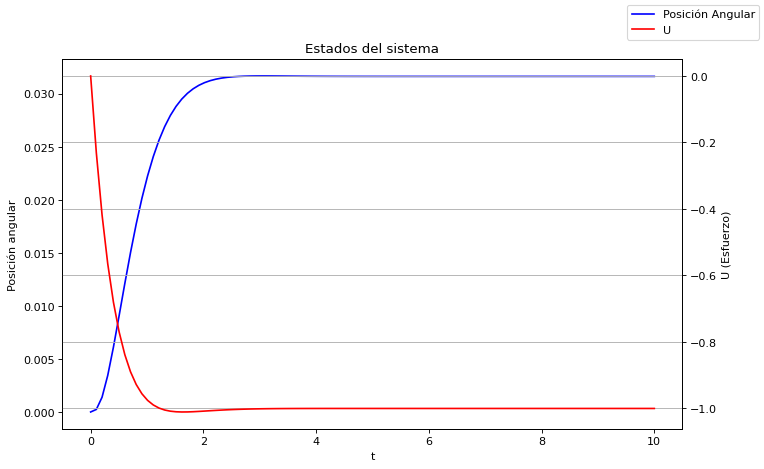

In [108]:
simulate_system(lqr_sys, K_lqr)